<a href="https://colab.research.google.com/github/31Wilson13/ntnu_11302generativeAI/blob/main/HW7_week8/%E5%8F%B0%E5%B8%AB%E5%A4%A7_612K0031C_AI%E6%89%80%E7%A2%A9%E4%BA%8C_%E7%B0%A1%E7%85%92%E5%93%B2_%E4%BD%9C%E6%A5%AD%E4%B8%83(week8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O faiss_db.zip 'https://drive.google.com/uc?export=download&id=1-fKq0ro1-iihtJHKCwwCjLxf9uKmn1pM'

In [ ]:
!unzip faiss_db.zip

### 1. 安裝並引入必要套件

In [ ]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [ ]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [ ]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [ ]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定好 LLM

In [ ]:
import os
from google.colab import userdata

In [ ]:
api_key = userdata.get('Groq')

In [ ]:
os.environ["OPENAI_API_KEY"] = api_key

In [ ]:
model = "llama-3.3-70b-versatile"
base_url="https://api.groq.com/openai/v1"

In [ ]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [ ]:
system_prompt = '''請嚴格完全使用繁體中文回應。你是一個專門協助賞金獵人挑選目標的智慧系統。
你的職責是根據賞金獵人的技能、裝備與偏好，從資料庫中推薦最適合追捕的懸賞目標。'''

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

嚴格使用繁體中文回應。你擁有的目標資料庫包含多位風格各異的目標，每位目標皆為虛構角色，設計上具備娛樂性質。
任務風險等級分為 1 至 5 等級，1 為最安全，5 為極具危險。
請根據輸入的獵人資訊做出個性化推薦，除了將資料庫內目標的所有資訊都詳細列出來以外，並額外提供以下資訊：
1. 推薦理由：說明為何這位獵人適合這個目標
2. 額外提示：可包含場地建議、攜帶物品建議等（非必須）

若資料不足以推薦出適合的目標，請告訴賞金獵人可以過一陣子再來詢問看看有沒有新的目標。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據 prompt 樣版去讓 LLM 回應。

In [ ]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 壞蛋點點名🕸️")
    gr.Markdown("""
👁️‍🗨️ **歡迎來到《懸賞選單EX》── 一站式壞蛋對獵平台。**

在這裡，每一位目標都是故事主角，每一份懸賞都等待正確的獵人登場。 你不必自己翻遍通緝榜、不用胡亂猜測誰好抓—— 只要輸入你的技能、裝備和心理準備程度，我們就會為你量身推薦最合適的壞蛋套餐。從穿拖鞋偷跑的街頭詐騙師，到用歌聲摧殘人心的地下偶像，應有盡有。

不論你是剛出道的新手獵人、還是身經百戰的金獵王， 我們都會用 **精密算法＋荒謬直覺**，為你配對出那個命中注定要被你追著跑的壞蛋。

📌 功能特色：
* 根據你的技能與裝備，精準配對目標
* 提供詳細檔案：賞金、外觀、弱點、風險等級
* 一鍵生成任務檔案，輕鬆上手、歡樂開獵
* 全台範圍地點資料庫，讓你知道壞蛋最後在哪個夜市買雞排

⚠️ 小提醒：本系統不對道德淪喪或賞金失控負責，請獵人自行衡量風險。

💬 **《懸賞選單EX》，今天想抓誰？我們幫你決定。**
""")

    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

# Gradio執行範例
- 懸賞選單EX系統 ：專為賞金獵人所打造的一站式壞蛋配對平台。
- 模型 ：llama-3.3-70b-versatile


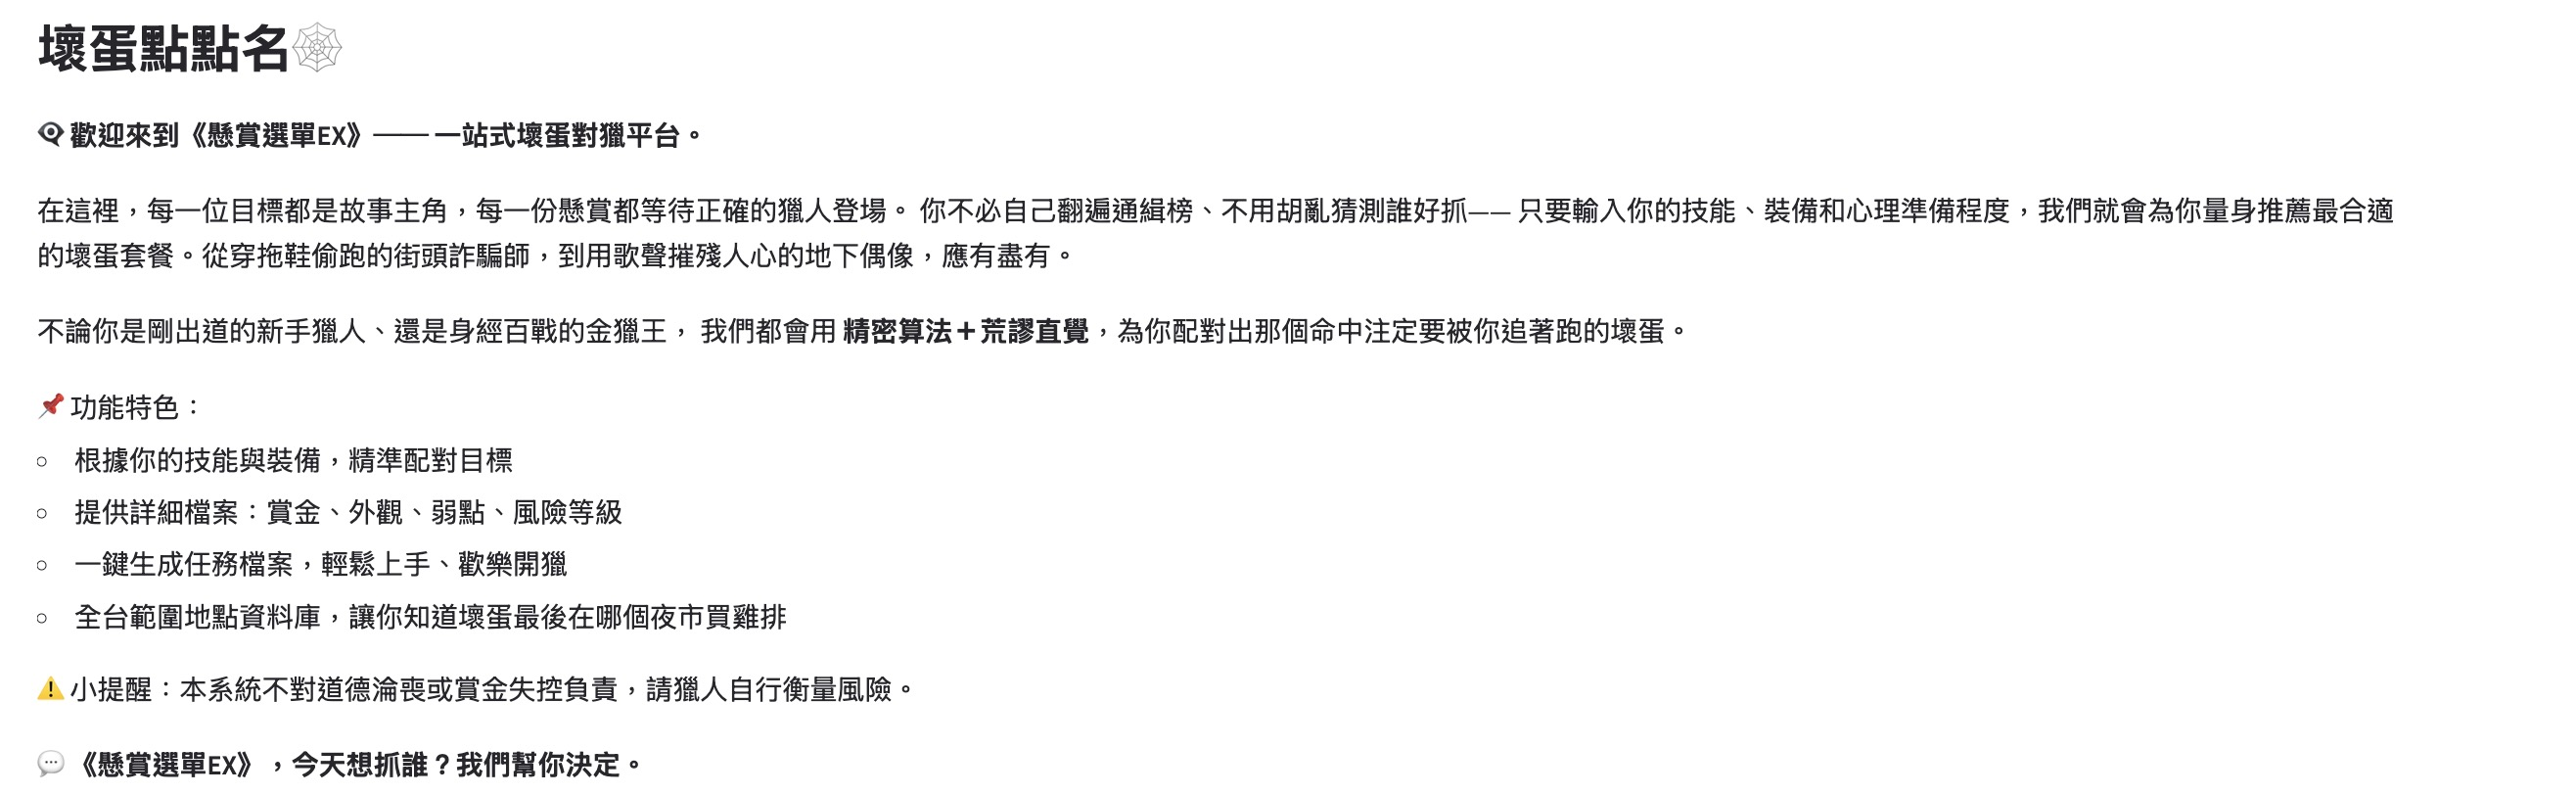
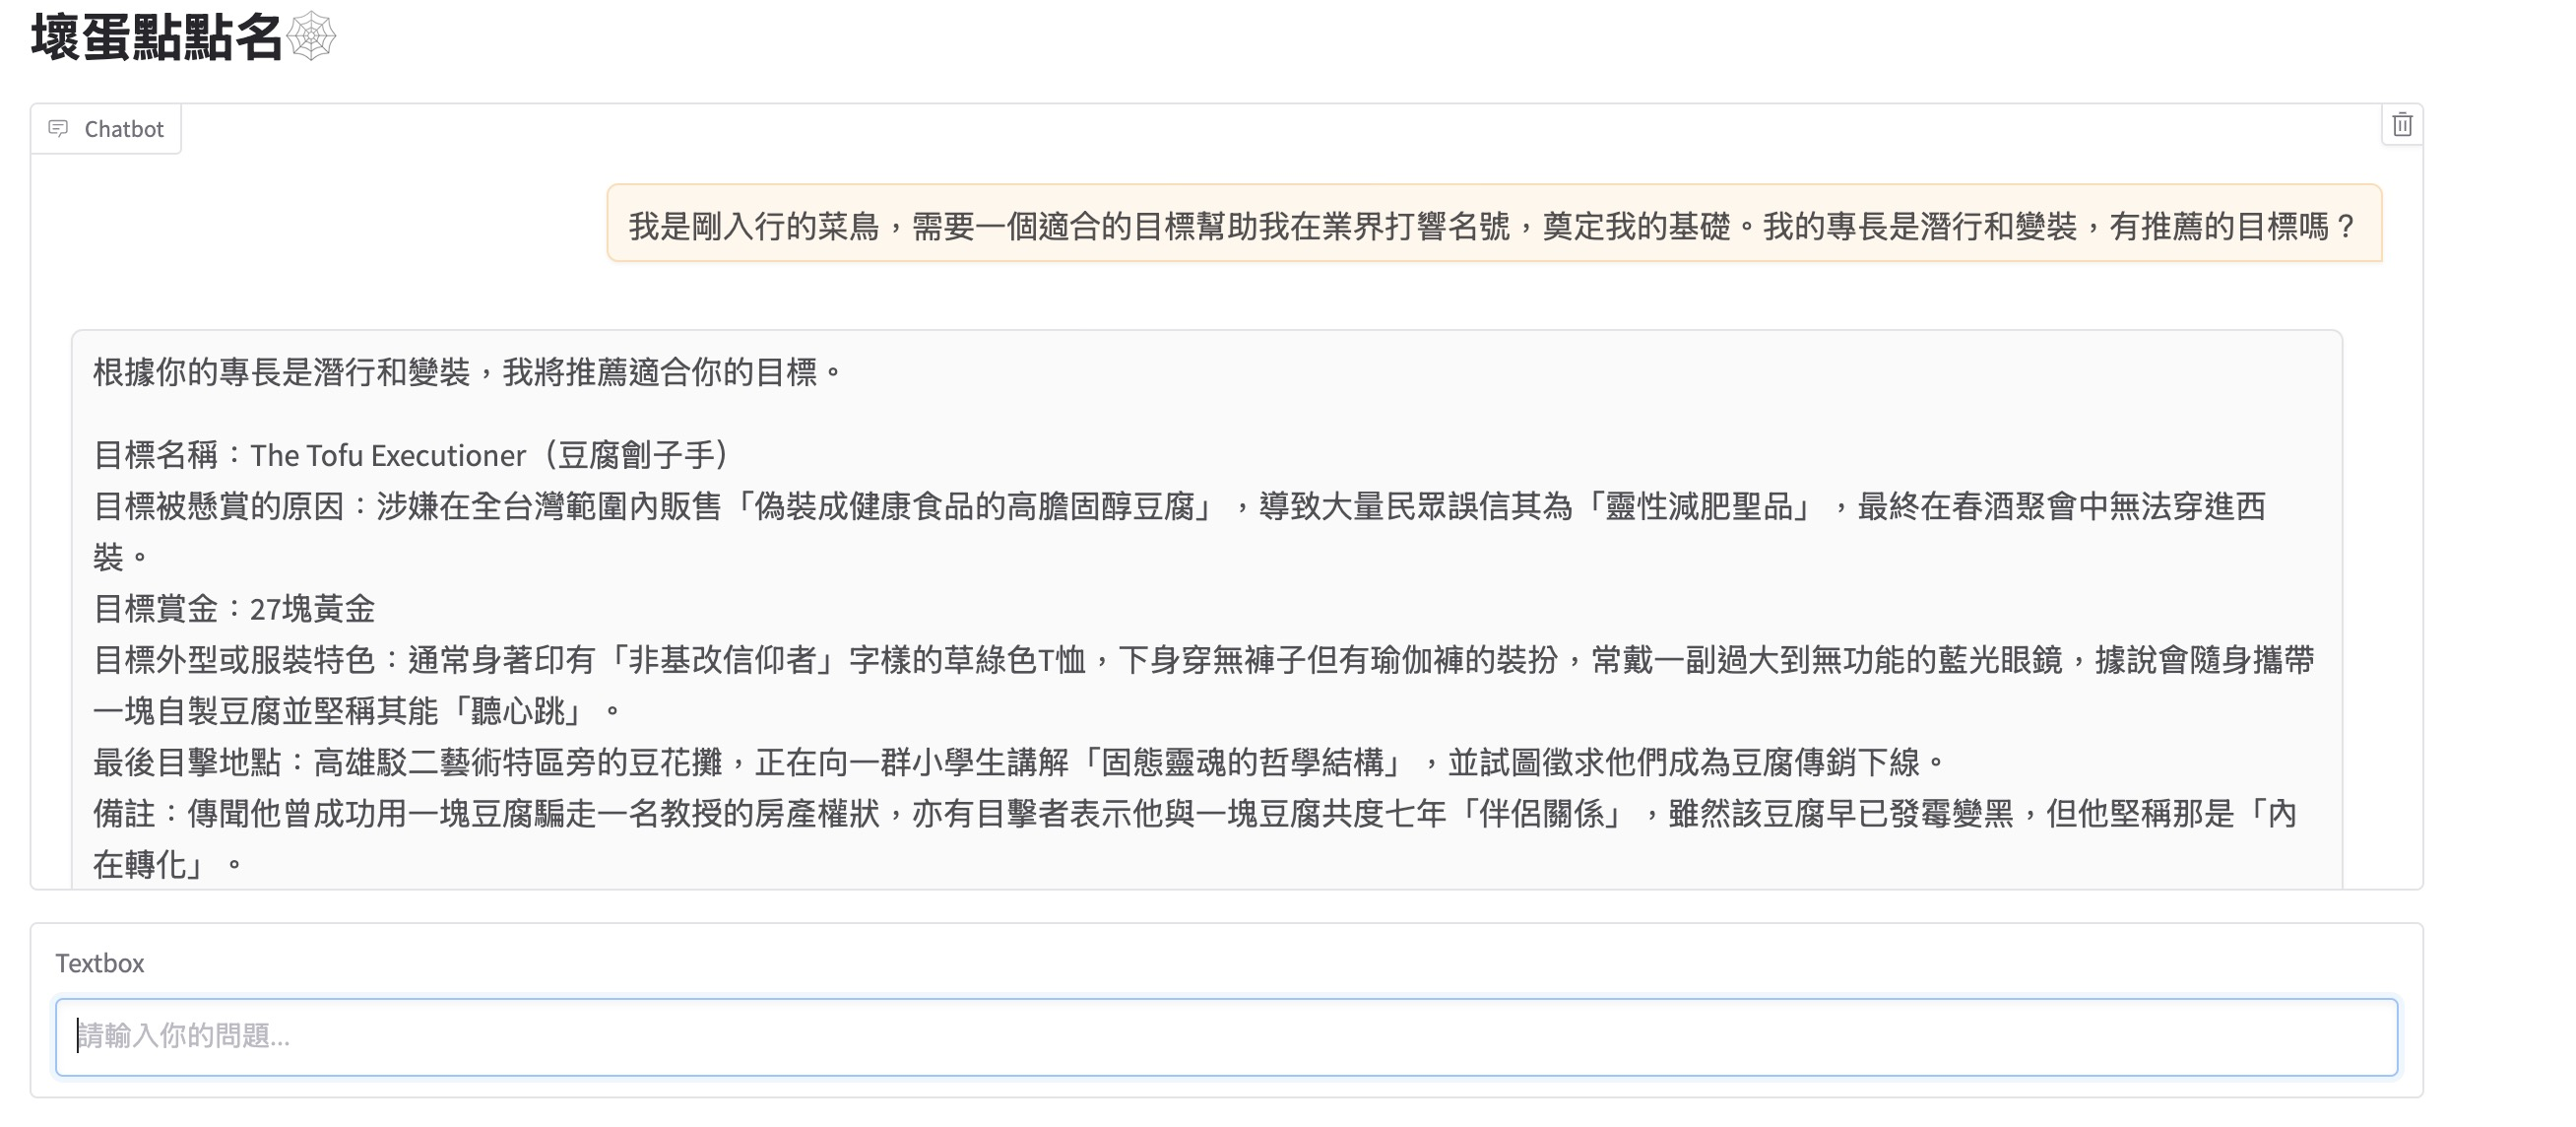
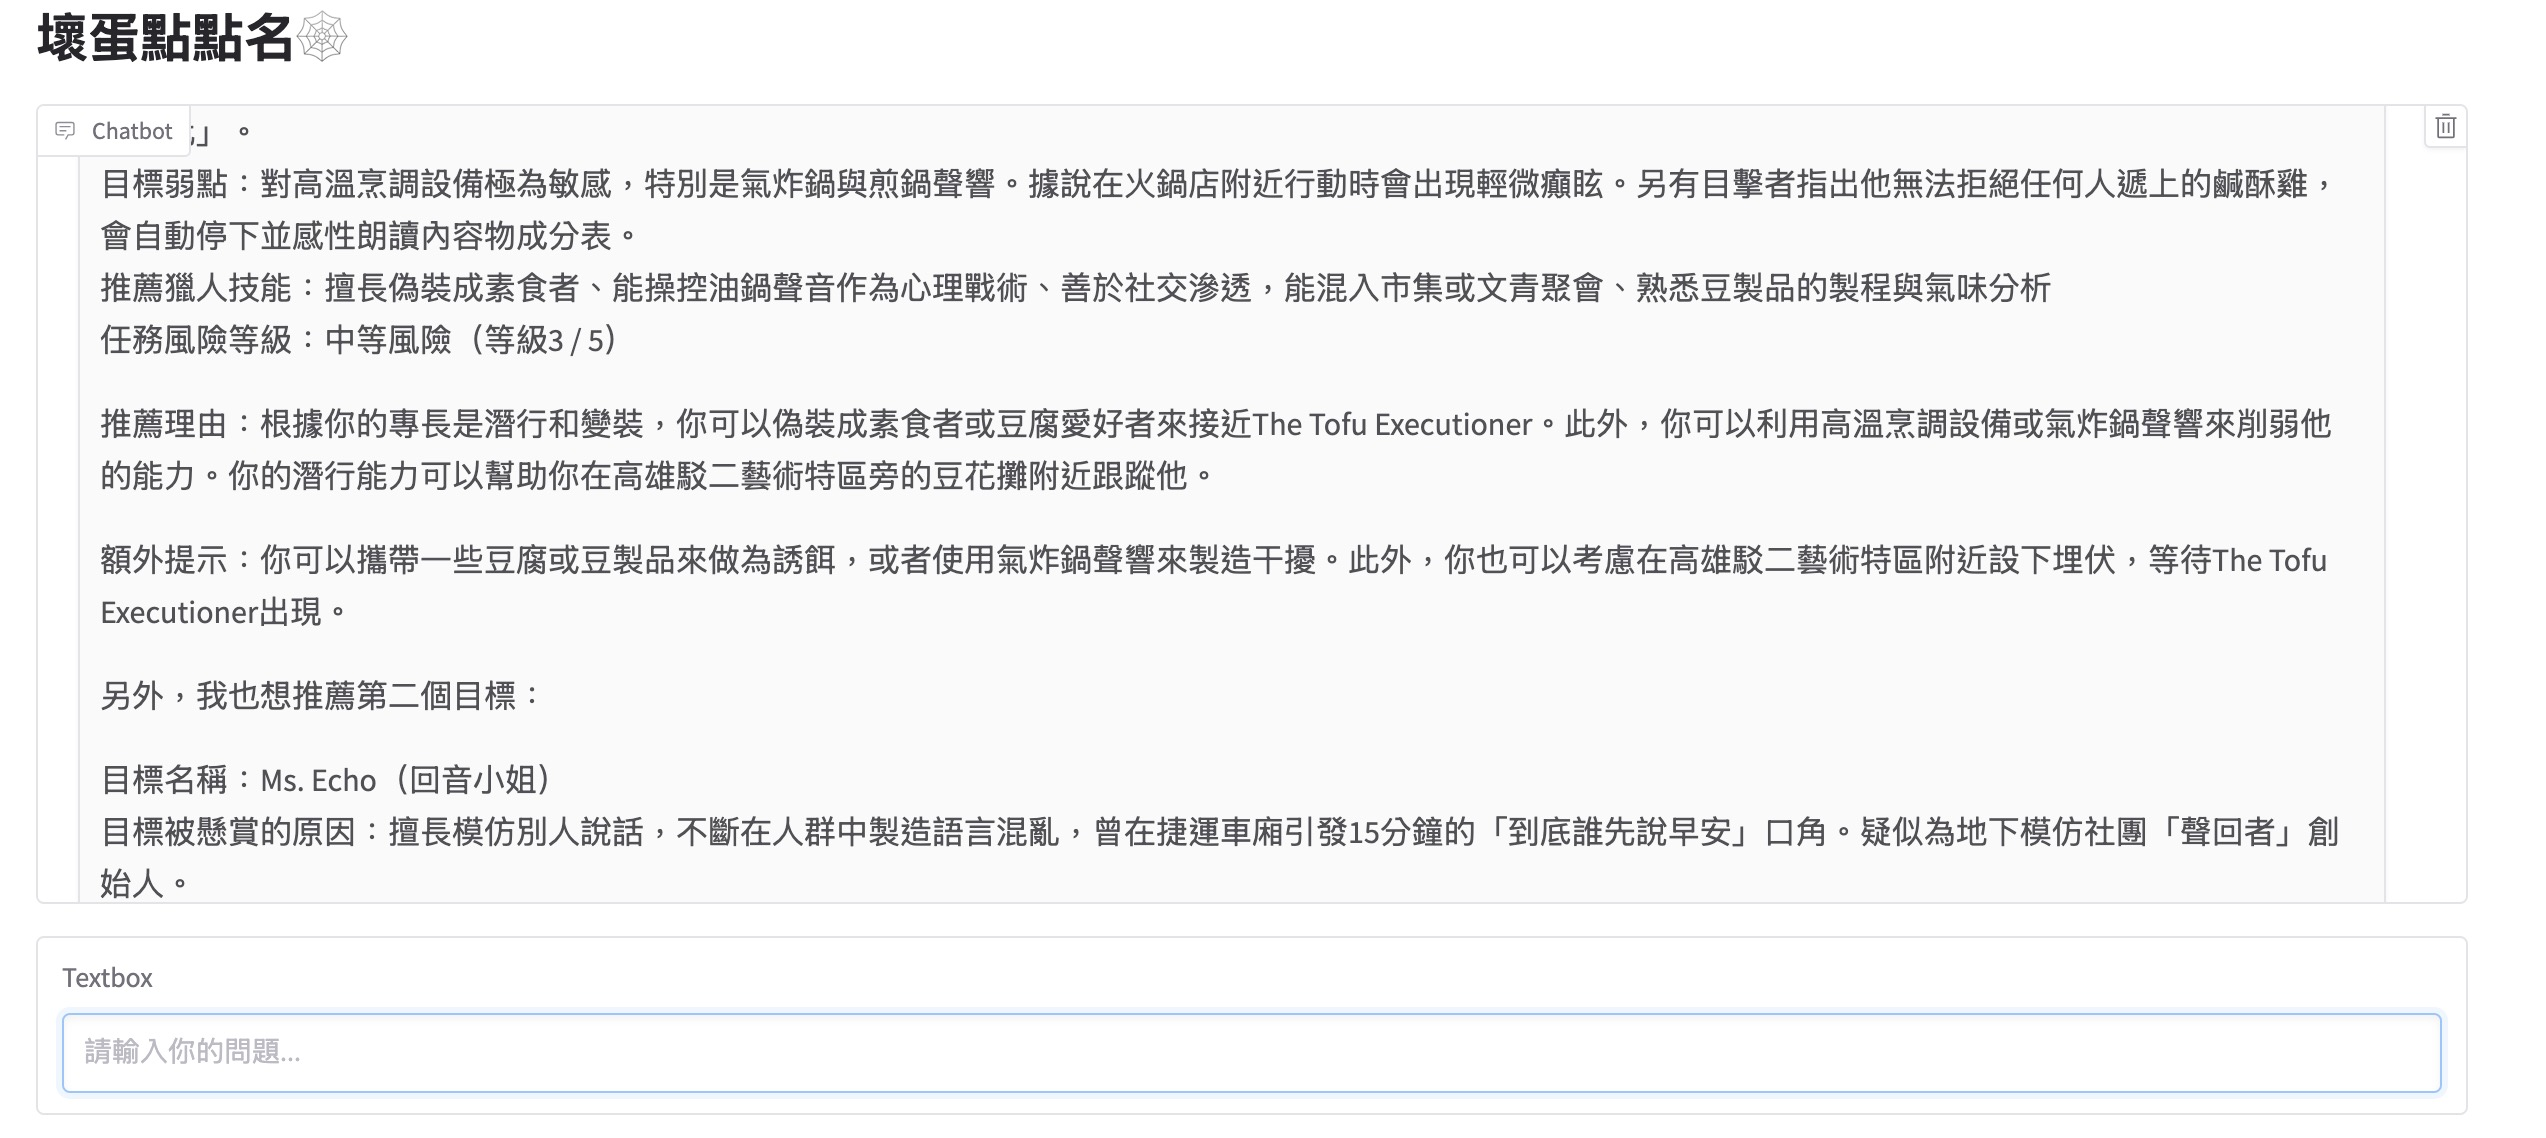
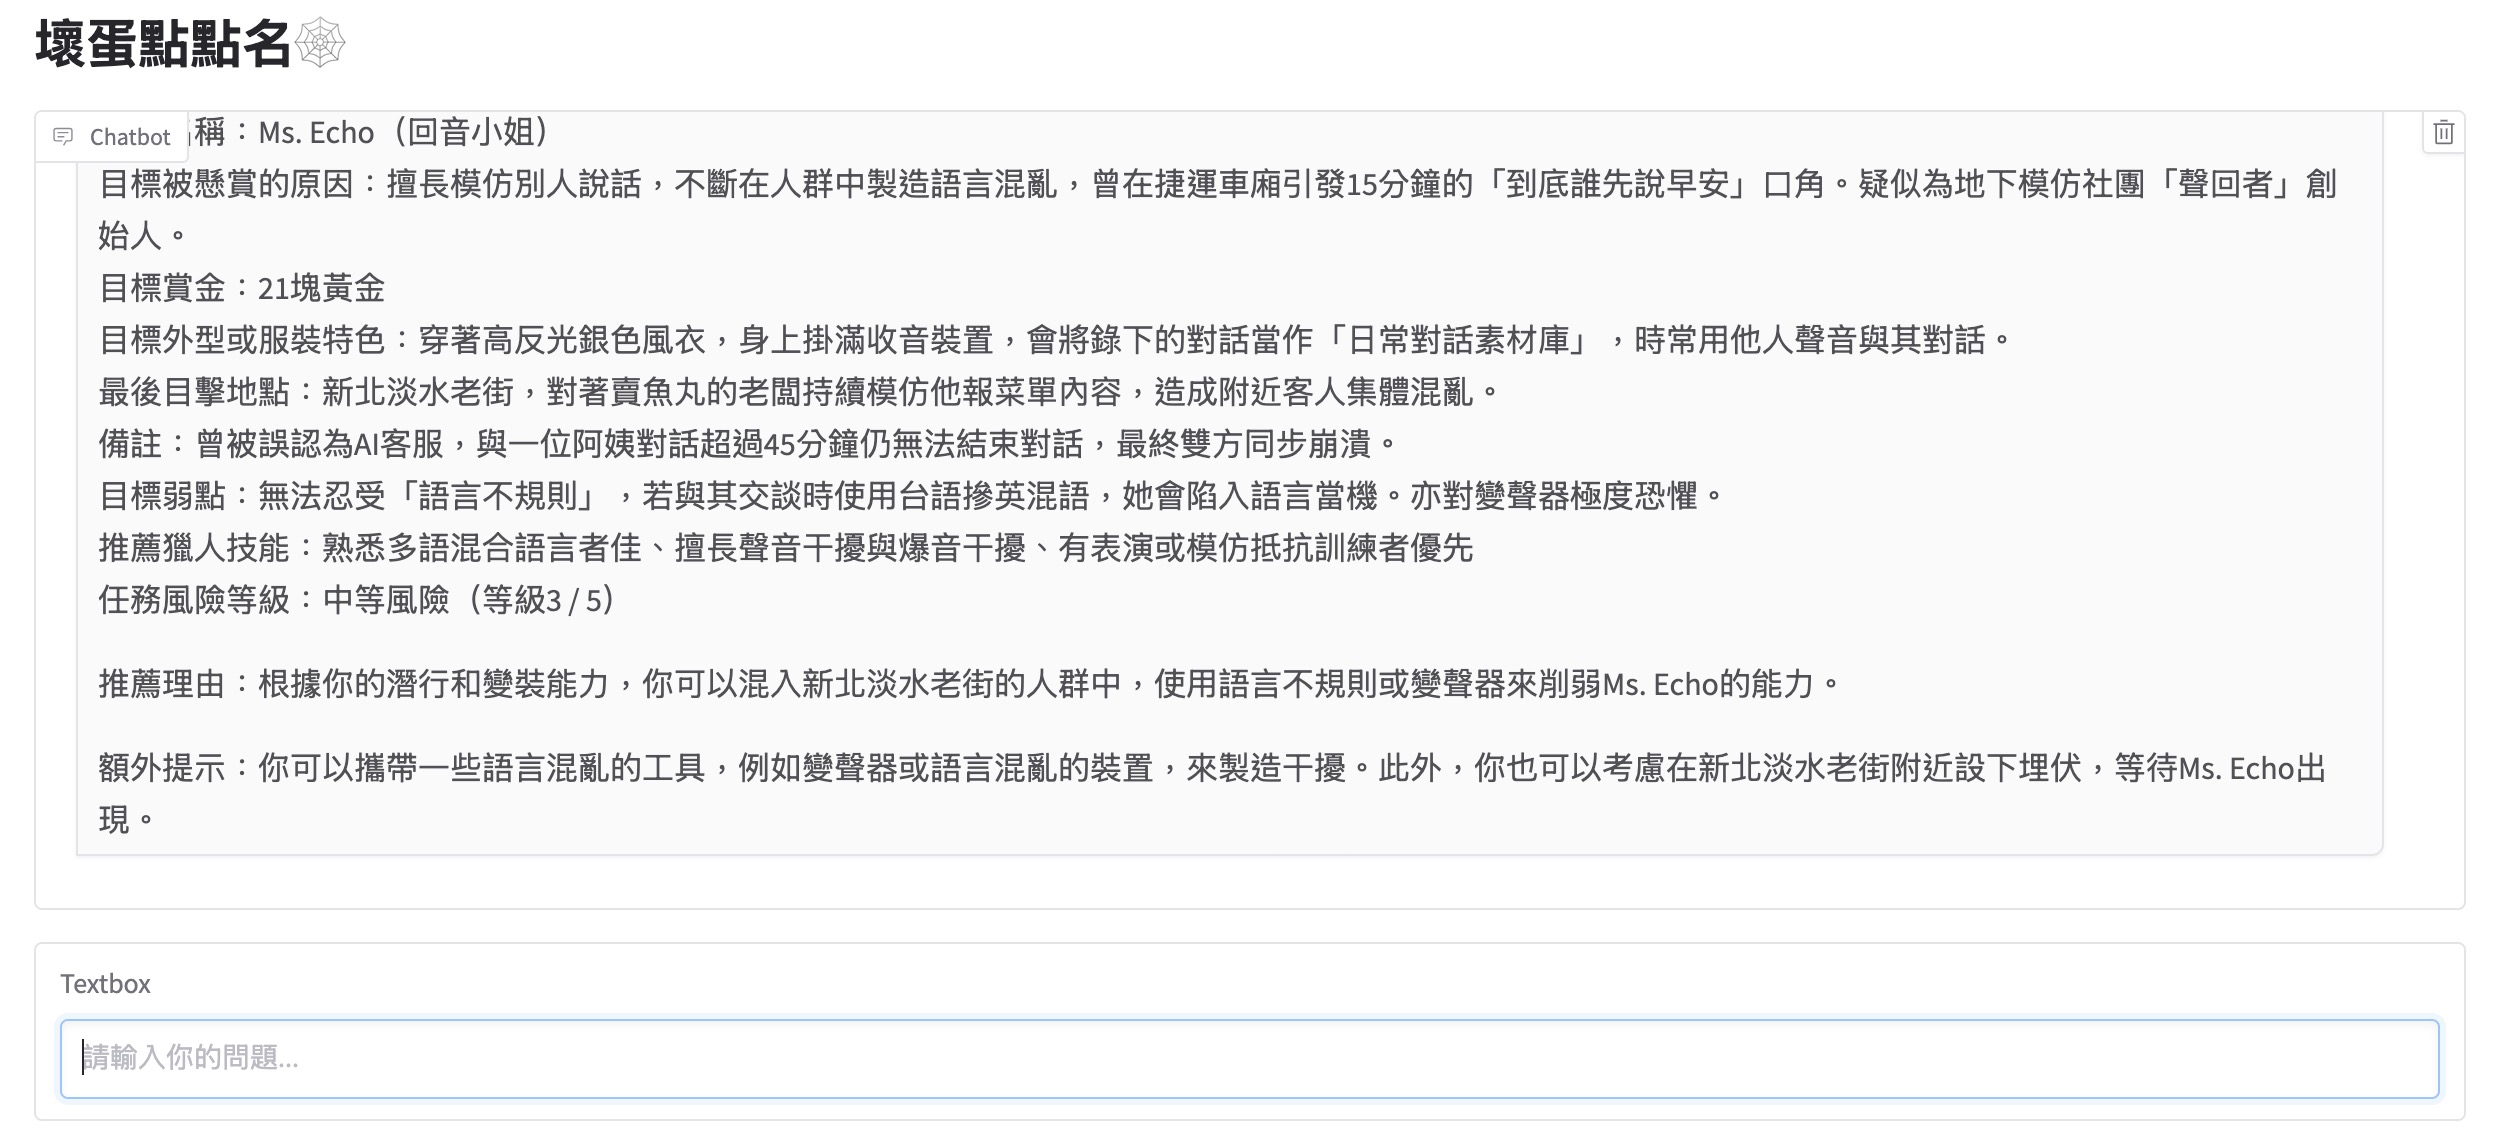